In [1]:
import sys

module_dir = '../'

if module_dir not in sys.path:
    sys.path.append(module_dir)

import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from models import *
import test_systems_1d as systems_1d
import itertools
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import NoNorm
from tqdm import tqdm
import gpjax as gpx
from sklearn.decomposition import PCA
import scipy.io
from scipy.interpolate import griddata

/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_data(ntrain, ntest):
    # amount of subsampling
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = scipy.io.loadmat("../burgers_data/burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float32)
    y_data = data["u"][:, ::sub_y].astype(np.float32)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]

    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]

    x_train = (x_branch_train, grid)
    x_test = (x_branch_test, grid)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_data(1000, 1000)

print(x_train[0].shape, x_train[1].shape, y_train.shape)
print(x_test[0].shape, x_test[1].shape, y_test.shape)

(1000, 128) (128, 1) (1000, 128)
(1000, 128) (128, 1) (1000, 128)


Training example

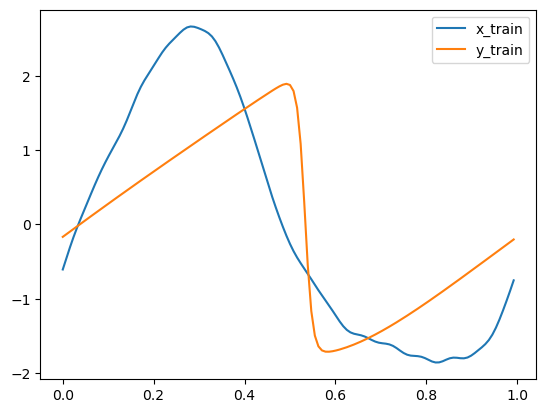

In [3]:
index_to_plot = 127

plt.figure()
plt.plot(x_train[1], x_train[0][index_to_plot, :].T, label="x_train")
plt.plot(x_train[1], y_train[index_to_plot, :].T, label="y_train")
plt.legend()
plt.show()

# Training

Check the PCA components

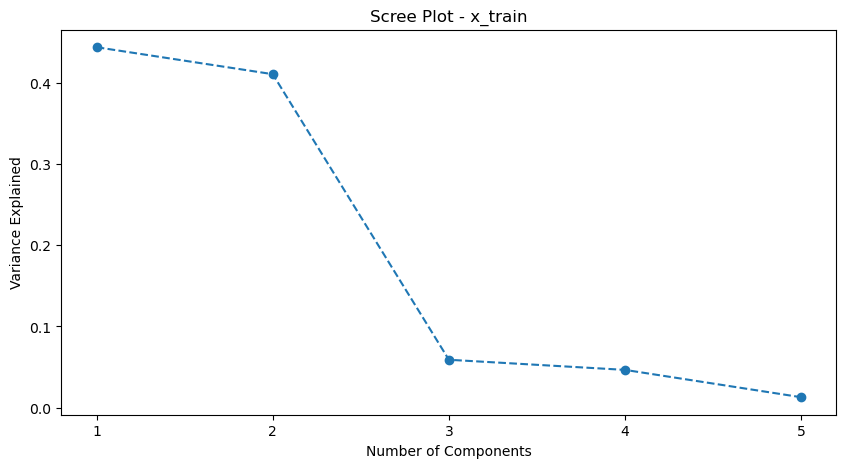

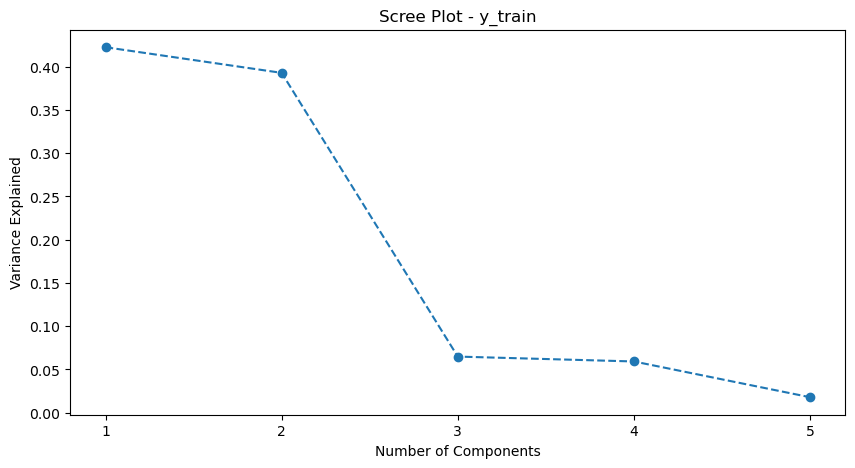

In [4]:
x_pca = PCA(n_components=5)
y_pca = PCA(n_components=5)
x_lowdim = x_pca.fit_transform(x_train[0])
y_lowdim = y_pca.fit_transform(y_train)

x_explained_variance = x_pca.explained_variance_ratio_
y_explained_variance = y_pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(x_explained_variance) + 1), x_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - x_train')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(x_explained_variance) + 1))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(y_explained_variance) + 1), y_explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot - y_train')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(y_explained_variance) + 1))
plt.show()

Train

(1000, 2)
(1000, 5)
GP
(1000, 5)


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 456.343140
         Iterations: 30
         Function evaluations: 82
         Gradient evaluations: 71


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 493.482544
         Iterations: 17
         Function evaluations: 98
         Gradient evaluations: 87


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 1163.904419
         Iterations: 18
         Function evaluations: 95
         Gradient evaluations: 85


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 1095.485718
         Iterations: 21
         Function evaluations: 171
         Gradient evaluations: 157


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 606.030151
         Iterations: 15
         Function evaluations: 157
         Gradient evaluations: 146
(1000, 5)
[<models.GP_regressor object at 0x7fab29593ee0>, <models.GP_regressor object at 0x7fab404f6260>, <models.GP_regressor object at 0x7fab404f6050>, <models.GP_regressor object at 0x7fab404f74c0>, <models.GP_regressor object at 0x7fab404f66b0>]


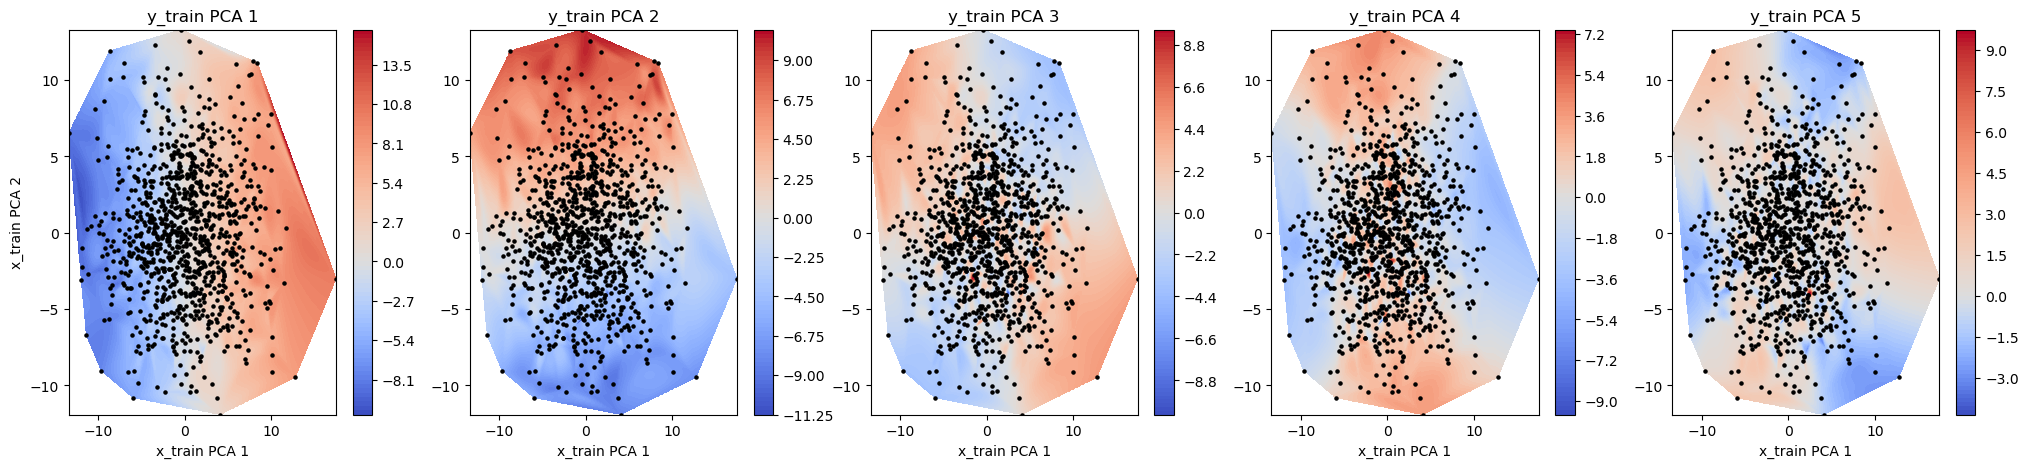

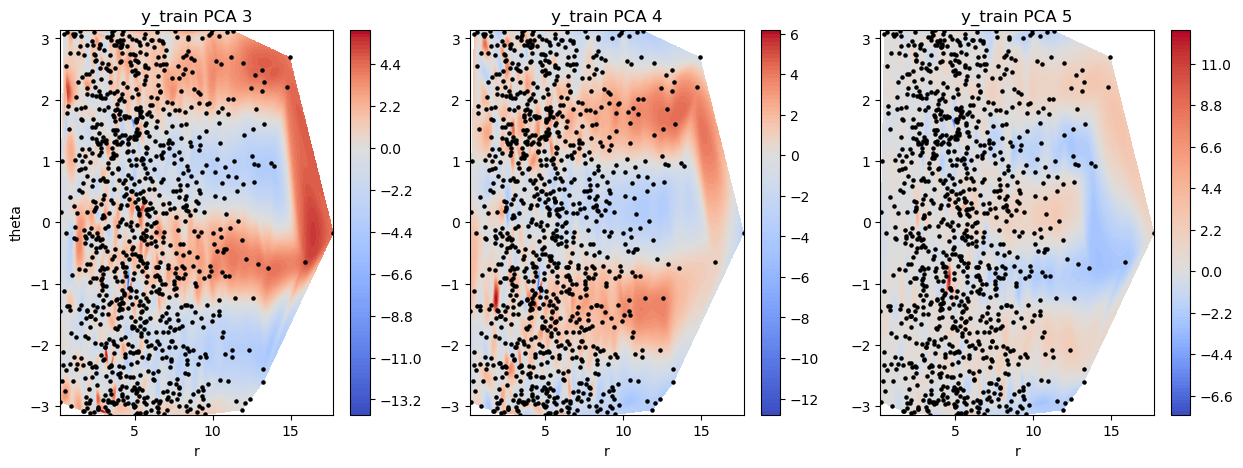

In [13]:
debug = True

low_dim_x = 2
low_dim_y = 5
GP_params = {'kernel': gpx.kernels.RBF(), 'mean_function': gpx.mean_functions.Zero()}

# reg = first_model(low_dim_x=low_dim_x, low_dim_y=low_dim_y, low_dim_regressor='GP', GP_params=GP_params)
# reg.fit(x_train[0], y_train, save=True)

print(reg.low_dim_regressor_list)

if debug and low_dim_x == 2:
    fig, ax = plt.subplots(1, low_dim_y, figsize=(5*low_dim_y, 5))
    for i in range(low_dim_y):
        x_PCA_1 = reg.X_train_low_dim[:, 0]
        x_PCA_2 = reg.X_train_low_dim[:, 1]
        y_PCA_i = reg.Y_train_low_dim[:, i]
        
        grid_x_PCA_1, grid_x_PCA_2 = np.meshgrid(np.linspace(x_PCA_1.min(), x_PCA_1.max(), 1000), np.linspace(x_PCA_2.min(), x_PCA_2.max(), 1000))
        grid_y_PCA_i = griddata((x_PCA_1, x_PCA_2), y_PCA_i, (grid_x_PCA_1, grid_x_PCA_2), method='linear')

        cf = ax[i].contourf(grid_x_PCA_1, grid_x_PCA_2, grid_y_PCA_i, levels=100, cmap='coolwarm', norm=TwoSlopeNorm(vcenter=0))
        ax[i].scatter(x_PCA_1, x_PCA_2, c='k', s=5)
        fig.colorbar(cf, ax=ax[i])
        
        ax[i].set_title(f"y_train PCA {i+1}")
        ax[i].set_xlabel("x_train PCA 1")
    ax[0].set_ylabel("x_train PCA 2")
    plt.show()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(2, 5):
        x_PCA_1 = reg.X_train_low_dim[:, 0]
        x_PCA_2 = reg.X_train_low_dim[:, 1]

        r = np.sqrt(x_PCA_1**2 + x_PCA_2**2)
        theta = np.arctan2(x_PCA_2, x_PCA_1)
        
        y_PCA_i = reg.Y_train_low_dim[:, i]
        
        grid_r, grid_theta = np.meshgrid(np.linspace(r.min(), r.max(), 1000), np.linspace(theta.min(), theta.max(), 1000))
        grid_y_PCA_i = griddata((r, theta), y_PCA_i, (grid_r, grid_theta), method='linear')

        cf = ax[i-2].contourf(grid_r, grid_theta, grid_y_PCA_i, levels=100, cmap='coolwarm', norm=TwoSlopeNorm(vcenter=0))
        ax[i-2].scatter(r, theta, c='k', s=5)
        fig.colorbar(cf, ax=ax[i-2])
        
        ax[i-2].set_title(f"y_train PCA {i+1}")
        ax[i-2].set_xlabel("r")
    ax[0].set_ylabel("theta")
    plt.show()

See how well the low dim regressor is doing

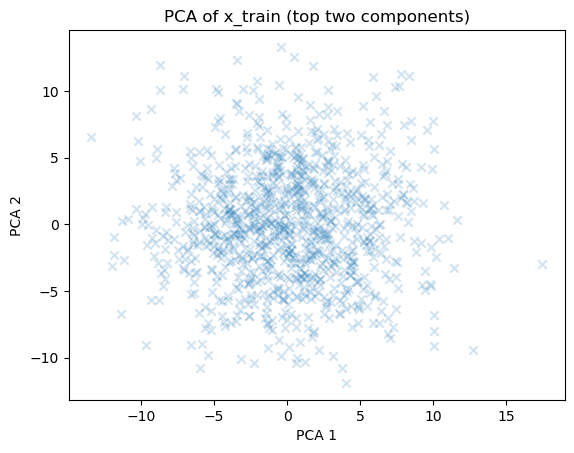

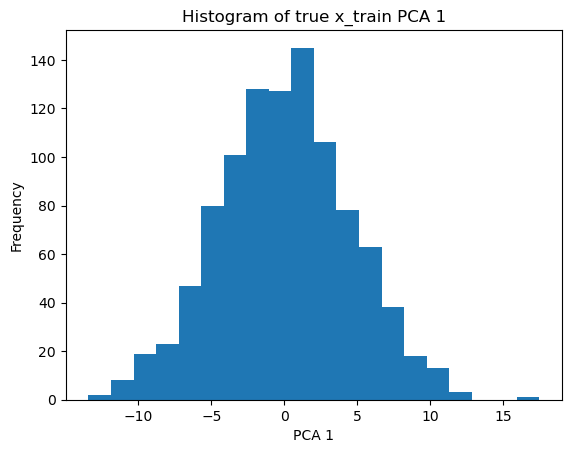

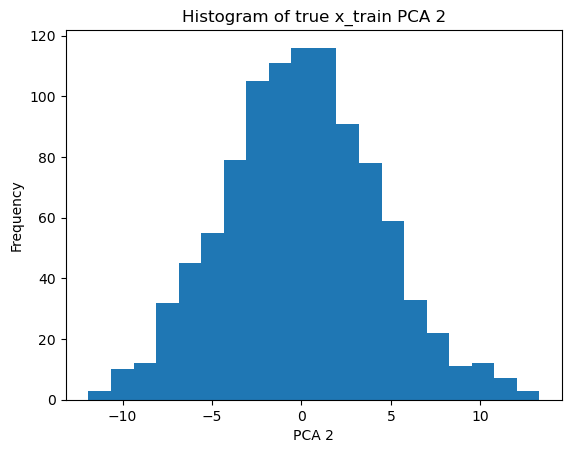

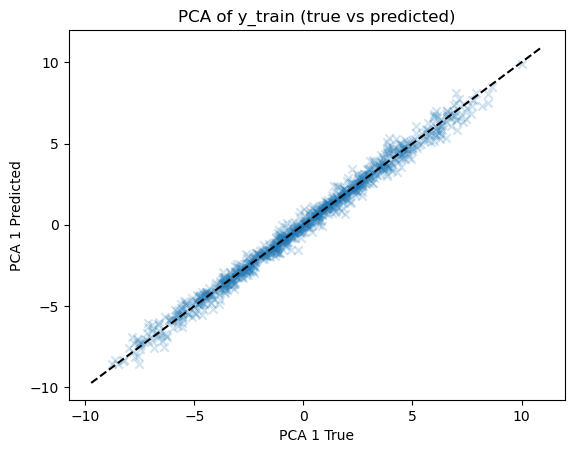

MSE: 0.13469607395719044
Correlation: 0.9948536674457168


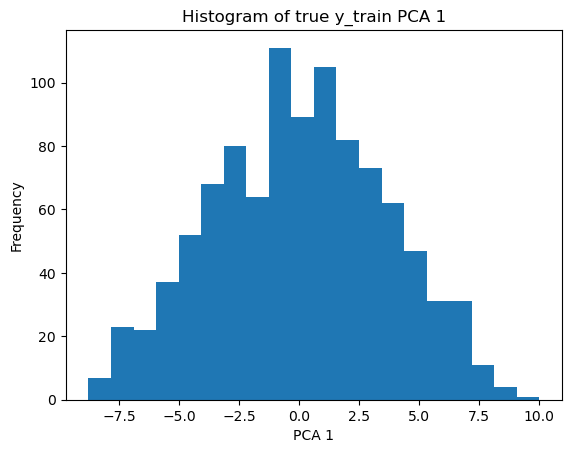

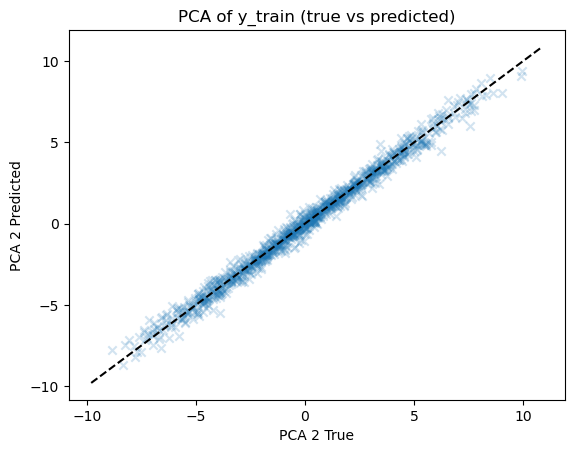

MSE: 0.14472580084484069
Correlation: 0.994051011602631


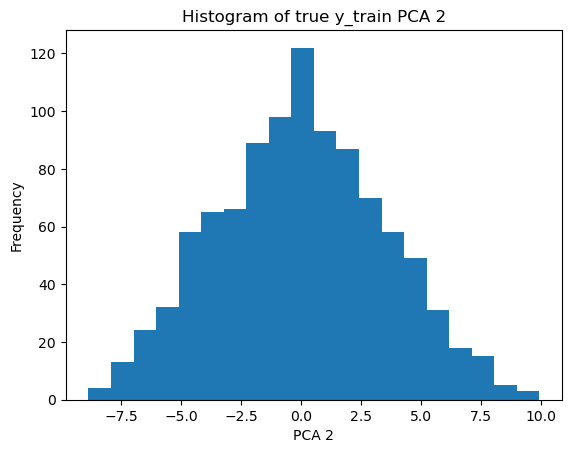

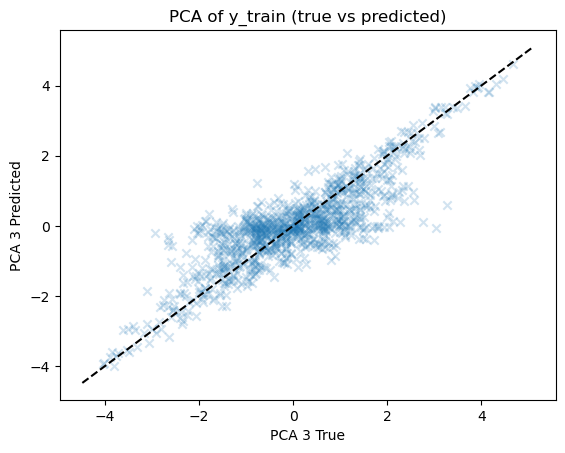

MSE: 0.5573248827180367
Correlation: 0.8506382210652933


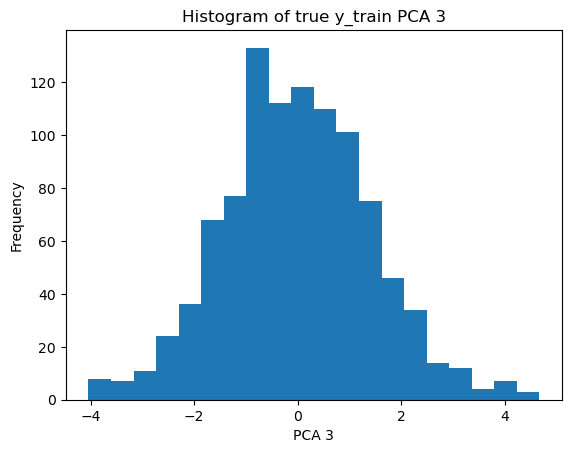

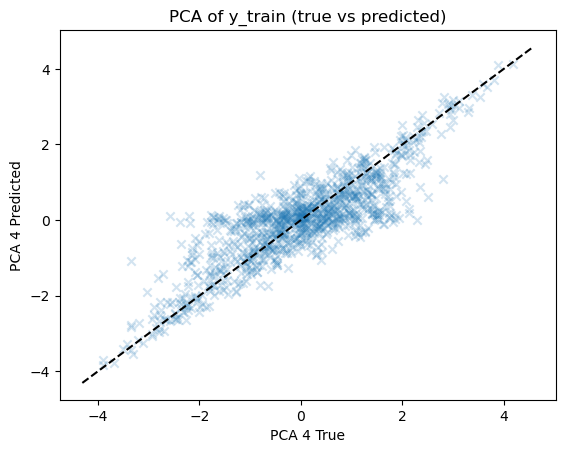

MSE: 0.48612726534987133
Correlation: 0.857885732591519


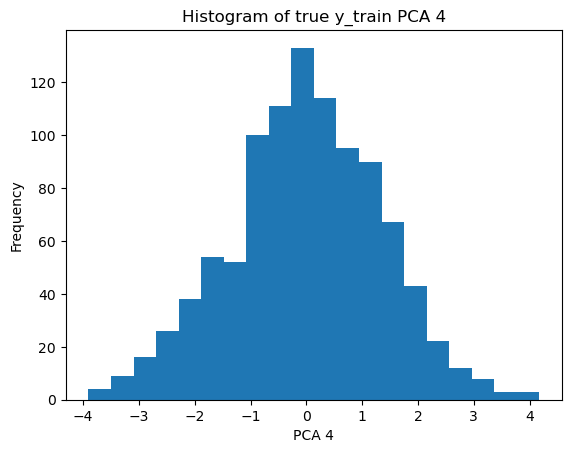

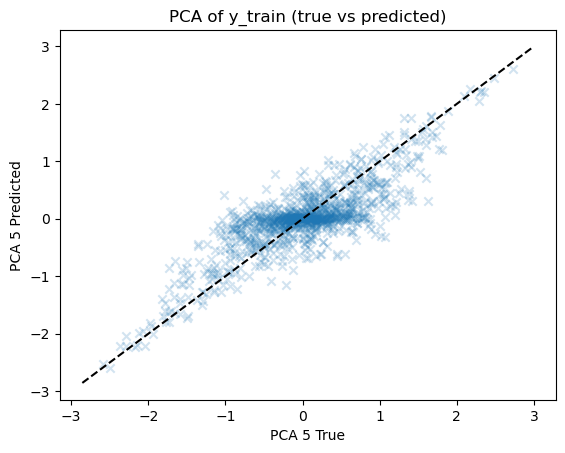

MSE: 0.17623886283215814
Correlation: 0.8270058092270546


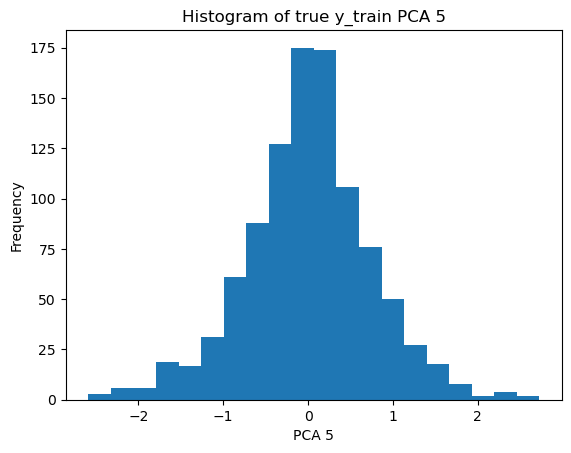

In [6]:
# assess how well the low-dimensional regression is doing

if low_dim_x > 1:
    plt.figure()
    plt.scatter(reg.X_train_low_dim[:, 0], reg.X_train_low_dim[:, 1], marker='x', alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('PCA of x_train (top two components)')
    plt.show()
if low_dim_x == 1:
    for i in range(low_dim_y):
        plt.figure()
        plt.scatter(reg.X_train_low_dim[:, 0], reg.Y_train_low_dim[:, i], marker='x', alpha=0.2)
        plt.plot(reg.X_train_low_dim[:, 0], reg.low_dim_regressor_list[i].predict(reg.X_train_low_dim), color='tab:orange', linestyle='None', marker='x', alpha=0.2)
        plt.xlabel('x_train PCA 1')
        plt.ylabel(f'y_train PCA {i+1}')
        plt.show()

for i in range(low_dim_x):
    plt.figure()
    plt.hist(reg.X_train_low_dim[:, i], bins=20)
    plt.xlabel(f'PCA {i+1}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of true x_train PCA {i+1}')
    plt.show()


for i in range(low_dim_y):
    plt.figure()
    ax = plt.gca()
    plt.scatter(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i], marker='x', alpha=0.2)
    plt.plot(np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), np.linspace(min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1]), num=2), linestyle='--', color='black')
    plt.xlabel(f'PCA {i+1} True')
    plt.ylabel(f'PCA {i+1} Predicted')
    plt.title('PCA of y_train (true vs predicted)')
    plt.show()

    mse = skl.metrics.mean_squared_error(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i])
    print(f'MSE: {mse}')
    r = np.corrcoef(reg.Y_train_low_dim[:, i], reg.Y_train_low_dim_pred[:, i])
    print(f'Correlation: {r[0, 1]}')

    plt.figure()
    plt.hist(reg.Y_train_low_dim[:, i], bins=20)
    plt.xlabel(f'PCA {i+1}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of true y_train PCA {i+1}')
    plt.show()

# Testing

In [7]:
y_test_pred = reg.predict(x_test[0])
rmse, r2 = reg.test(x_test[0], y_test)
L2_relative_error = np.sqrt(np.sum((y_test - y_test_pred) ** 2, axis = 1))/np.sqrt(np.sum(y_test ** 2, axis = 1))

print(f' average L2 error: {L2_relative_error.mean()}')

 average L2 error: 0.34956511371593524


Plot the distributions of errors (not sure if RMSE and R2 are the best here)

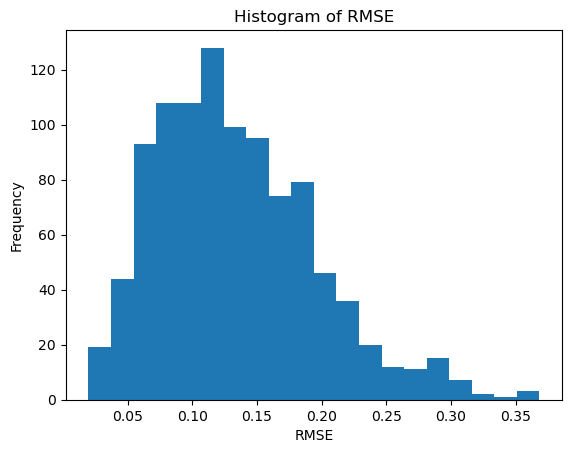

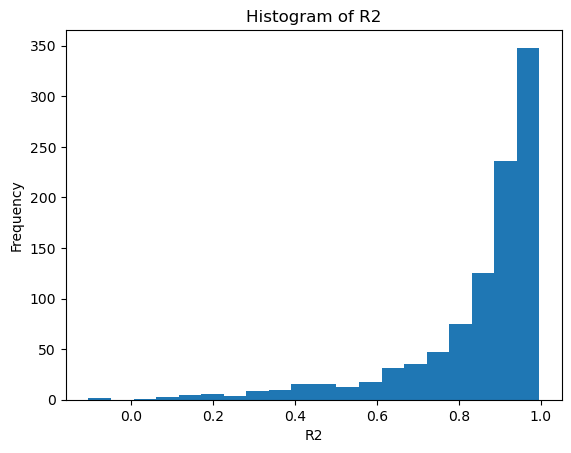

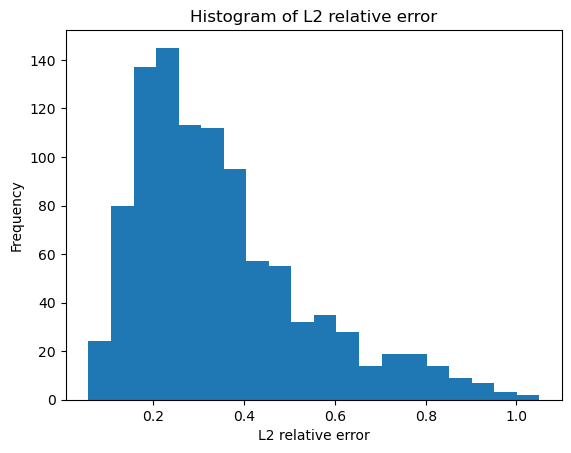

In [8]:
plt.figure()
plt.hist(rmse, bins=20)
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Histogram of RMSE')
plt.show()

plt.figure()
plt.hist(r2, bins=20)
plt.xlabel('R2')
plt.ylabel('Frequency')
plt.title('Histogram of R2')
plt.show()

plt.figure()
plt.hist(L2_relative_error, bins=20)
plt.xlabel('L2 relative error')
plt.ylabel('Frequency')
plt.title('Histogram of L2 relative error')
plt.show()

plot an example test

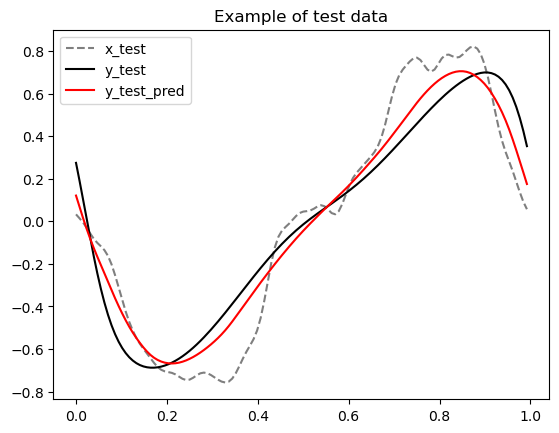

In [9]:
index_to_plot = 1

plt.figure()
plt.plot(x_test[1], x_test[0][index_to_plot, :].T, label="x_test", linestyle='--', color='black', alpha=0.5)
plt.plot(x_test[1], y_test[index_to_plot, :].T, label="y_test", color='black')
plt.plot(x_test[1], y_test_pred[index_to_plot, :].T, label="y_test_pred", color='red')
plt.legend()
plt.title('Example of test data')
plt.show()
